In [1]:
# Basic Libraries
import pandas as pd
import numpy as np

# Visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Text Libraries
import nltk
import string
import re

# Feature Extraction Libraries
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split

# Classifier Model libraries
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import tree

# Performance Matrix libraries
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

import warnings
warnings.filterwarnings('ignore')



---

#1. Load Dataset

---



In [2]:
import pandas as pd

data = pd.read_parquet("hf://datasets/dair-ai/emotion/unsplit/train-00000-of-00001.parquet")
data

,text,label
0,i feel awful about it too because it s my job ...,0
1,im alone i feel awful,0
2,ive probably mentioned this before but i reall...,1
3,i was feeling a little low few days back,0
4,i beleive that i am much more sensitive to oth...,2
...,...,...
416804,that was what i felt when i was finally accept...,1
416805,i take every day as it comes i m just focussin...,4
416806,i just suddenly feel that everything was fake,0
416807,im feeling more eager than ever to claw back w...,1


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416809 entries, 0 to 416808
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    416809 non-null  object
 1   label   416809 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 6.4+ MB


In [4]:
data.isna().sum()

,0
text,0
label,0


In [5]:
data.isnull().sum()

,0
text,0
label,0


In [6]:
data['label'].unique()

array([0, 1, 2, 3, 4, 5])

In [7]:
#0. sadness, 1. joy, 2. love, 3. anger, 4. fear, 5. surprise
label_mapping = {
    0: "sadness",
    1: "joy",
    2: "love",
    3: "anger",
    4: "fear",
    5: "surprise"
}

data['label'] = data['label'].map(label_mapping)

In [8]:
data['label'].value_counts()


,count
label,
joy,141067
sadness,121187
anger,57317
fear,47712
love,34554
surprise,14972


<Axes: xlabel='label', ylabel='count'>

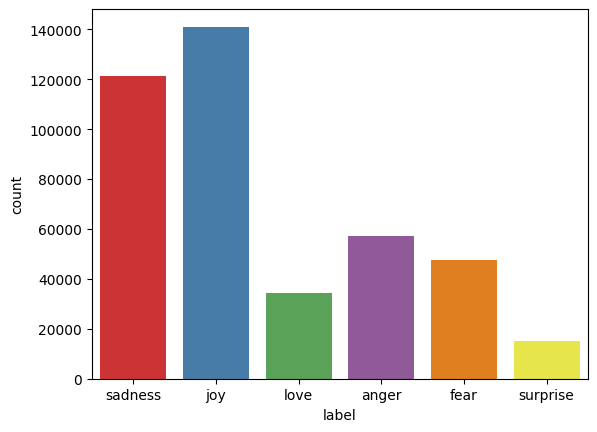

In [9]:
sns.countplot(x='label', data=data, hue='label',palette='Set1')

In [10]:
num_instance = min(data['label'].value_counts())
df = data.groupby("label", group_keys=False).apply(lambda x: x.sample(n=num_instance, random_state=42))

print(df["label"].value_counts())

label
anger       14972
fear        14972
joy         14972
love        14972
sadness     14972
surprise    14972
Name: count, dtype: int64


In [11]:
df['label'].value_counts()

,count
label,
anger,14972
fear,14972
joy,14972
love,14972
sadness,14972
surprise,14972




---
#Dataset Emotion Analysis
---



<Axes: xlabel='label', ylabel='count'>

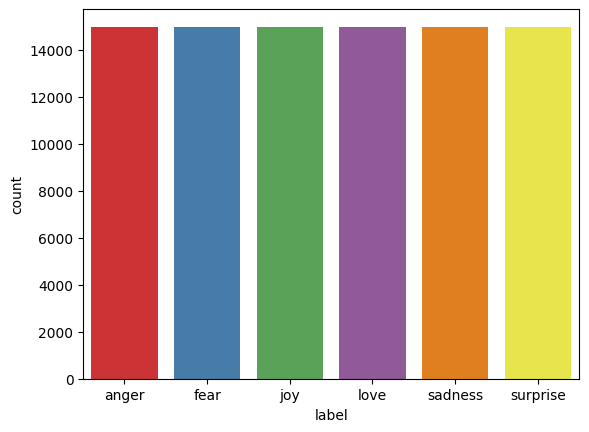

In [12]:
#0. sadness, 1. joy, 2. love, 3. anger, 4. fear, 5. surprise
sns.countplot(x='label', data=df, hue='label',palette='Set1')



---
#2. Pre-processing text data

---




##2.1. Remove Punctuations

In [13]:
emojis = pd.read_csv('/content/emojis.txt',sep=',',header=None)
emojis_dict = {i:j for i,j in zip(emojis[0],emojis[1])}
pattern = '|'.join(sorted(re.escape(k) for k in emojis_dict))

def replace_emojis(text):
    text = re.sub(pattern,lambda m: emojis_dict.get(m.group(0)), text, flags=re.IGNORECASE)
    return text

def remove_punct(text):
    text = replace_emojis(text)
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    return text

df['Text_punct'] = df['text'].apply(lambda x: remove_punct(x))
df.head(10)

,text,label,Text_punct
411459,i feel irritated and i kinda hate this feeling,anger,i feel irritated and i kinda hate this feeling
18514,id rather be home feeling violent and lonely i...,anger,id rather be home feeling violent and lonely i...
281385,i suggest you wait to discuss this with them u...,anger,i suggest you wait to discuss this with them u...
50441,i wrong to feel royally pissed off at all this,anger,i wrong to feel royally pissed off at all this
95314,im so tierd of talking about him like theres h...,anger,im so tierd of talking about him like theres h...
24535,i feel frustrated and to be honest like i didn...,anger,i feel frustrated and to be honest like i didn...
111166,i try to make changes where i feel an urge to ...,anger,i try to make changes where i feel an urge to ...
139353,i truly don t have a good feel for this fight ...,anger,i truly don t have a good feel for this fight ...
354088,i was just feeling jealous,anger,i was just feeling jealous
129547,i feel angry i just think of what it was like ...,anger,i feel angry i just think of what it was like ...


##2.2 Tokenization

In [14]:
def tokenization(text):
    text = text.lower()
    text = re.split('\W+', text)

    return text

df['Text_tokenized'] = df['Text_punct'].apply(lambda x: tokenization(x.lower()))
df.head(10)

,text,label,Text_punct,Text_tokenized
411459,i feel irritated and i kinda hate this feeling,anger,i feel irritated and i kinda hate this feeling,"[i, feel, irritated, and, i, kinda, hate, this..."
18514,id rather be home feeling violent and lonely i...,anger,id rather be home feeling violent and lonely i...,"[id, rather, be, home, feeling, violent, and, ..."
281385,i suggest you wait to discuss this with them u...,anger,i suggest you wait to discuss this with them u...,"[i, suggest, you, wait, to, discuss, this, wit..."
50441,i wrong to feel royally pissed off at all this,anger,i wrong to feel royally pissed off at all this,"[i, wrong, to, feel, royally, pissed, off, at,..."
95314,im so tierd of talking about him like theres h...,anger,im so tierd of talking about him like theres h...,"[im, so, tierd, of, talking, about, him, like,..."
24535,i feel frustrated and to be honest like i didn...,anger,i feel frustrated and to be honest like i didn...,"[i, feel, frustrated, and, to, be, honest, lik..."
111166,i try to make changes where i feel an urge to ...,anger,i try to make changes where i feel an urge to ...,"[i, try, to, make, changes, where, i, feel, an..."
139353,i truly don t have a good feel for this fight ...,anger,i truly don t have a good feel for this fight ...,"[i, truly, don, t, have, a, good, feel, for, t..."
354088,i was just feeling jealous,anger,i was just feeling jealous,"[i, was, just, feeling, jealous]"
129547,i feel angry i just think of what it was like ...,anger,i feel angry i just think of what it was like ...,"[i, feel, angry, i, just, think, of, what, it,..."


##2.3 Remove Stopwords

In [15]:
import nltk
nltk.download('stopwords')
stopword = nltk.corpus.stopwords.words('english')
stopword.extend(['yr', 'year', 'woman', 'man', 'girl','boy','one', 'two', 'sixteen', 'yearold', 'fu', 'weeks', 'week',
              'treatment', 'associated', 'patients', 'may','day', 'case','old','u','n','didnt','ive','ate','feel','keep'
                ,'brother','dad','basic','im'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
def remove_stopwords(text):
    text = [word for word in text if word not in stopword]
    return text

df['Text_nonstop'] = df['Text_tokenized'].apply(lambda x: remove_stopwords(x))
df.head(10)

,text,label,Text_punct,Text_tokenized,Text_nonstop
411459,i feel irritated and i kinda hate this feeling,anger,i feel irritated and i kinda hate this feeling,"[i, feel, irritated, and, i, kinda, hate, this...","[irritated, kinda, hate, feeling]"
18514,id rather be home feeling violent and lonely i...,anger,id rather be home feeling violent and lonely i...,"[id, rather, be, home, feeling, violent, and, ...","[id, rather, home, feeling, violent, lonely, t..."
281385,i suggest you wait to discuss this with them u...,anger,i suggest you wait to discuss this with them u...,"[i, suggest, you, wait, to, discuss, this, wit...","[suggest, wait, discuss, feeling, less, resent..."
50441,i wrong to feel royally pissed off at all this,anger,i wrong to feel royally pissed off at all this,"[i, wrong, to, feel, royally, pissed, off, at,...","[wrong, royally, pissed]"
95314,im so tierd of talking about him like theres h...,anger,im so tierd of talking about him like theres h...,"[im, so, tierd, of, talking, about, him, like,...","[tierd, talking, like, theres, hope, hell, car..."
24535,i feel frustrated and to be honest like i didn...,anger,i feel frustrated and to be honest like i didn...,"[i, feel, frustrated, and, to, be, honest, lik...","[frustrated, honest, like, get, moneys, worth,..."
111166,i try to make changes where i feel an urge to ...,anger,i try to make changes where i feel an urge to ...,"[i, try, to, make, changes, where, i, feel, an...","[try, make, changes, urge, happen, particularl..."
139353,i truly don t have a good feel for this fight ...,anger,i truly don t have a good feel for this fight ...,"[i, truly, don, t, have, a, good, feel, for, t...","[truly, good, fight, ever, bothered]"
354088,i was just feeling jealous,anger,i was just feeling jealous,"[i, was, just, feeling, jealous]","[feeling, jealous]"
129547,i feel angry i just think of what it was like ...,anger,i feel angry i just think of what it was like ...,"[i, feel, angry, i, just, think, of, what, it,...","[angry, think, like, elsewhere]"


##2.4 Lemmatization

In [17]:
nltk.download('wordnet')
wn = nltk.WordNetLemmatizer()

def lemmatizer(text):
    text = [wn.lemmatize(word) for word in text]
    return text

df['Text_lemmatized'] = df['Text_nonstop'].apply(lambda x: lemmatizer(x))
df.head()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,text,label,Text_punct,Text_tokenized,Text_nonstop,Text_lemmatized
411459,i feel irritated and i kinda hate this feeling,anger,i feel irritated and i kinda hate this feeling,"[i, feel, irritated, and, i, kinda, hate, this...","[irritated, kinda, hate, feeling]","[irritated, kinda, hate, feeling]"
18514,id rather be home feeling violent and lonely i...,anger,id rather be home feeling violent and lonely i...,"[id, rather, be, home, feeling, violent, and, ...","[id, rather, home, feeling, violent, lonely, t...","[id, rather, home, feeling, violent, lonely, t..."
281385,i suggest you wait to discuss this with them u...,anger,i suggest you wait to discuss this with them u...,"[i, suggest, you, wait, to, discuss, this, wit...","[suggest, wait, discuss, feeling, less, resent...","[suggest, wait, discus, feeling, less, resentful]"
50441,i wrong to feel royally pissed off at all this,anger,i wrong to feel royally pissed off at all this,"[i, wrong, to, feel, royally, pissed, off, at,...","[wrong, royally, pissed]","[wrong, royally, pissed]"
95314,im so tierd of talking about him like theres h...,anger,im so tierd of talking about him like theres h...,"[im, so, tierd, of, talking, about, him, like,...","[tierd, talking, like, theres, hope, hell, car...","[tierd, talking, like, there, hope, hell, care..."


##Token Frequency in a sentence after preprocessing

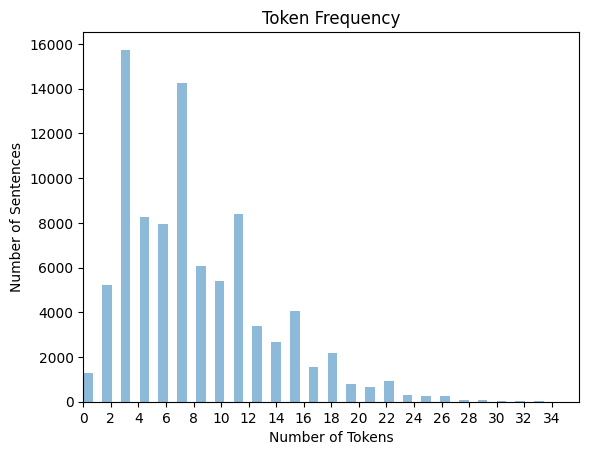

In [18]:
token_lengths = [len(t) for t in df['Text_lemmatized']]
plt.hist(token_lengths,bins=33,width = 0.7, fc="green",alpha=0.5)
plt.xlabel('Number of Tokens')
plt.ylabel('Number of Sentences')
plt.title('Token Frequency')
x_Values = [i for i in range(36)]

plt.xticks(x_Values[::2])
plt.xlim(0,36)
plt.rcParams["figure.figsize"] = (10,8)
plt.show()

##All in one (Text preprocessing)

In [19]:
def clean_text(text):
    text = remove_punct(text)
    text = tokenization(text)
    text = remove_stopwords(text)
    text = lemmatizer(text)
    return text



---

#3. Feature Extraction

---



In [20]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'],test_size=0.3, random_state = 0)

In [21]:
countVectorizer1 = CountVectorizer(analyzer=clean_text)
countVector1 = countVectorizer1.fit_transform(X_train)

countVector2 = countVectorizer1.transform(X_test)

tfidf_transformer_xtrain = TfidfTransformer()
x_train = tfidf_transformer_xtrain.fit_transform(countVector1)

tfidf_transformer_xtest = TfidfTransformer()
x_test = tfidf_transformer_xtest.fit_transform(countVector2)



---

#4. Models

---





1.   Support Vector Machine (SVM)
2.   Logistic Regression
3.   Random Forest Classifier



**Performance Matrix :**
1. **Accuracy** = $\frac{TP+TN}{TP+TN+FP+FN}$

2. **Precision** = $\frac{TP}{TP+FP}$

3. **Recall** = $\frac{TP}{TP+FN}$

4. **F1-score** = $\frac{2 \times Precision \times Recall}{Precision + Recall}$

##4.1 Support Vector Machine (SVM)

In [22]:
svm = SVC(kernel='linear',probability=True)

svm.fit(x_train, y_train)

y_pred = svm.predict(x_test)

svm_acc = accuracy_score(y_pred, y_test)
svm_prec = precision_score(y_test, y_pred, average='macro')
svm_recal = recall_score(y_test, y_pred, average='macro')
svm_cm = confusion_matrix(y_test,y_pred)
svm_f1 = f1_score(y_test, y_pred, average='macro')

print('Accuracy:', '{0:.3f}'.format(svm_acc*100))
print('Precision:', '{0:.3f}'.format(svm_prec*100))
print('Recall:', '{0:.3f}'.format(svm_recal*100))
print('F1-score:', '{0:.3f}'.format(svm_f1*100))
print(classification_report(y_test,y_pred))

Accuracy: 91.358
Precision: 91.488
Recall: 91.336
F1-score: 91.303
              precision    recall  f1-score   support

       anger       0.93      0.90      0.92      4466
        fear       0.89      0.87      0.88      4417
         joy       0.94      0.86      0.90      4460
        love       0.90      0.97      0.93      4548
     sadness       0.95      0.89      0.92      4574
    surprise       0.88      0.98      0.93      4485

    accuracy                           0.91     26950
   macro avg       0.91      0.91      0.91     26950
weighted avg       0.91      0.91      0.91     26950



###4.1.1 Confusion Matrix

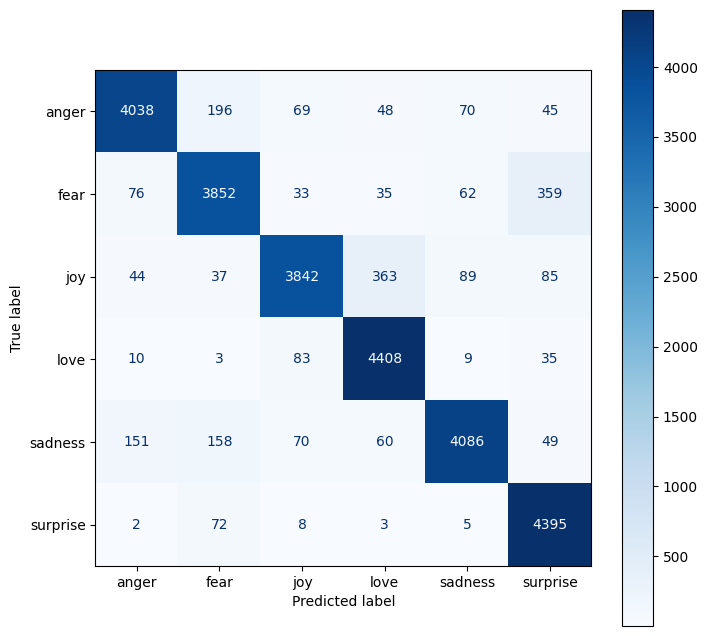

In [23]:
cm_display_svm = ConfusionMatrixDisplay(svm_cm, display_labels=svm.classes_)
fig, ax = plt.subplots(figsize=(8,8))
cm_display_svm.plot(ax=ax,cmap='Blues')

##4.2 Logistic Regression

In [24]:
logisticRegr = LogisticRegression()

logisticRegr.fit(x_train, y_train)

y_pred = logisticRegr.predict(x_test)

lr_acc = accuracy_score(y_pred, y_test)
lr_prec = precision_score(y_test, y_pred, average='macro')
lr_recal = recall_score(y_test, y_pred, average='macro')
lr_cm = confusion_matrix(y_test,y_pred)
lr_f1 = f1_score(y_test, y_pred, average='macro')

print('Accuracy:', '{0:.3f}'.format(lr_acc*100))
print('Precision:', '{0:.3f}'.format(lr_prec*100))
print('Recall:', '{0:.3f}'.format(lr_recal*100))
print('F1-score:', '{0:.3f}'.format(lr_f1*100))
print(classification_report(y_test,y_pred))

Accuracy: 91.165
Precision: 91.191
Recall: 91.143
F1-score: 91.124
              precision    recall  f1-score   support

       anger       0.93      0.91      0.92      4466
        fear       0.90      0.86      0.88      4417
         joy       0.91      0.88      0.89      4460
        love       0.90      0.95      0.93      4548
     sadness       0.94      0.90      0.92      4574
    surprise       0.89      0.96      0.93      4485

    accuracy                           0.91     26950
   macro avg       0.91      0.91      0.91     26950
weighted avg       0.91      0.91      0.91     26950



###4.2.1 Confusion Matrix

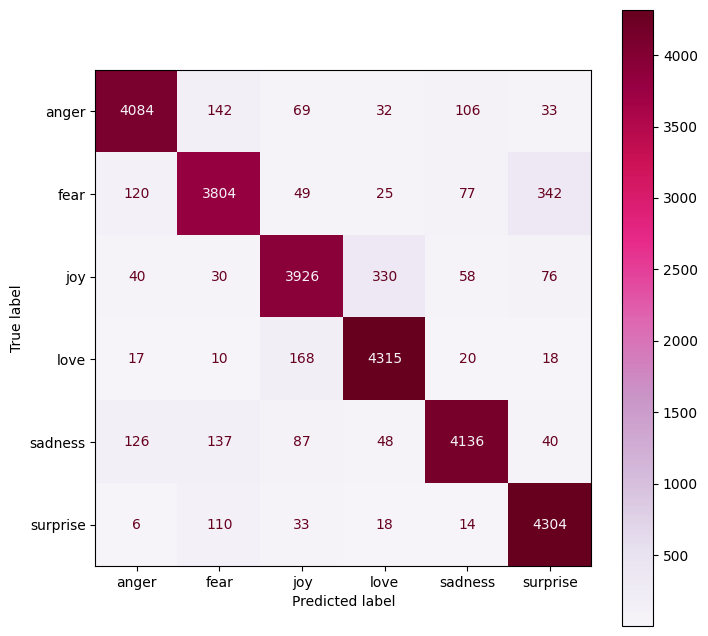

In [25]:
cm_display_lr = ConfusionMatrixDisplay(lr_cm, display_labels=logisticRegr.classes_)
fig, ax = plt.subplots(figsize=(8,8))
cm_display_lr.plot(ax=ax,cmap='PuRd')

##4.3 Random Forest Classifier

In [26]:
rfc = RandomForestClassifier(n_estimators=10, random_state=0)

rfc.fit(x_train, y_train)

y_pred = rfc.predict(x_test)

rfc_acc = accuracy_score(y_pred, y_test)
rfc_prec = precision_score(y_test, y_pred, average='macro')
rfc_recal = recall_score(y_test, y_pred, average='macro')
rfc_cm = confusion_matrix(y_test,y_pred)
rfc_f1 = f1_score(y_test, y_pred, average='macro')

print('Accuracy:', '{0:.3f}'.format(rfc_acc*100))
print('Precision:', '{0:.3f}'.format(rfc_prec*100))
print('Recall:', '{0:.3f}'.format(rfc_recal*100))
print('F1-score:', '{0:.3f}'.format(rfc_f1*100))
print(classification_report(y_test,y_pred))

Accuracy: 89.050
Precision: 89.077
Recall: 89.033
F1-score: 89.009
              precision    recall  f1-score   support

       anger       0.89      0.91      0.90      4466
        fear       0.85      0.85      0.85      4417
         joy       0.90      0.85      0.87      4460
        love       0.89      0.95      0.92      4548
     sadness       0.93      0.87      0.90      4574
    surprise       0.88      0.92      0.90      4485

    accuracy                           0.89     26950
   macro avg       0.89      0.89      0.89     26950
weighted avg       0.89      0.89      0.89     26950



###4.3.1 Confusion Matrix

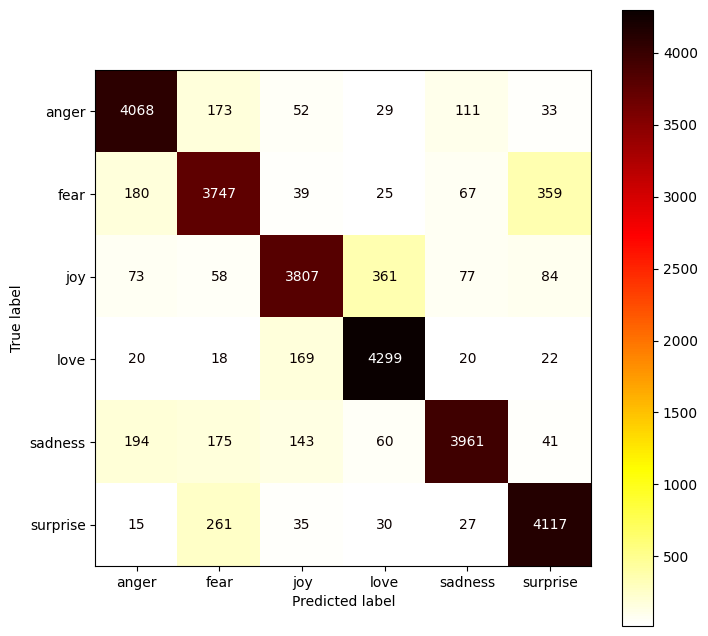

In [27]:
cm_display_rfc = ConfusionMatrixDisplay(rfc_cm, display_labels=rfc.classes_)
fig, ax = plt.subplots(figsize=(8,8))
cm_display_rfc.plot(ax=ax,cmap='hot_r')



---
#5. Summary Visualization
---



In [28]:
def get_prec_recall_per_emotion(cm):
    per_emotion_precision = []
    for i in range(len(cm)):
        count_per_emotion,accurate = 0,0
        for j in range(len(cm)):
            if i == j:
                accurate = cm[j][i]
            count_per_emotion += cm[j][i]
        per_emotion_precision.append(round((accurate/count_per_emotion)*100,3))

    per_emotion_recall = []
    for i in range(len(cm)):
        count_per_emotion,accurate = 0,0
        for j in range(len(cm)):
            if i == j:
                accurate = cm[i][j]
            count_per_emotion += cm[i][j]
        per_emotion_recall.append(round((accurate/count_per_emotion)*100,3))

    return per_emotion_precision, per_emotion_recall

##5.1. Precision of all models

In [29]:
svm_per_prec,svm_per_recall = get_prec_recall_per_emotion(svm_cm)
lr_per_prec,lr_per_recall = get_prec_recall_per_emotion(lr_cm)
rfc_per_prec,rfc_per_recall = get_prec_recall_per_emotion(rfc_cm)

per_precision_list = pd.DataFrame({'Support vector Machine' : svm_per_prec,
                                'Logistic Regression' : lr_per_prec,
                                'Random Forest' : rfc_per_prec},
                                index=svm.classes_)
per_precision_list

,Support vector Machine,Logistic Regression,Random Forest
anger,93.451,92.966,89.407
fear,89.208,89.865,84.544
joy,93.593,90.628,89.682
love,89.648,90.499,89.488
sadness,94.561,93.766,92.916
surprise,88.466,89.424,88.424


##5.2. Recall of all models

In [30]:
per_recall_list = pd.DataFrame({'Support vector Machine' : svm_per_recall,
                                'Logistic Regression' : lr_per_recall,
                                'Random Forest' : rfc_per_recall},
                                index=svm.classes_)
per_recall_list

,Support vector Machine,Logistic Regression,Random Forest
anger,90.416,91.446,91.088
fear,87.209,86.122,84.831
joy,86.143,88.027,85.359
love,96.922,94.877,94.525
sadness,89.331,90.424,86.598
surprise,97.993,95.964,91.795


##5.3 Accuracy Visualization for all models

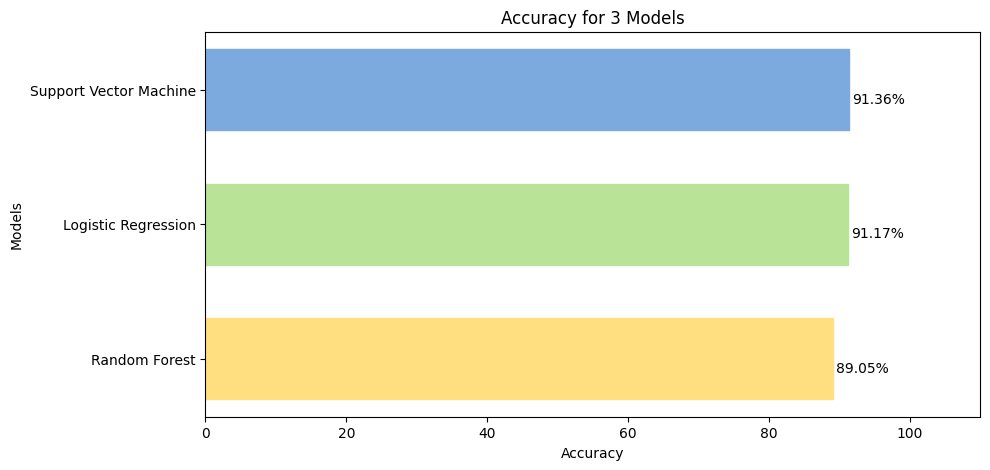

In [31]:
algorithms = ['Random Forest','Logistic Regression','Support Vector Machine']
algorithm_acc = [rfc_acc*100, lr_acc*100, svm_acc*100]

# Figure Size
fig = plt.figure(figsize =(10, 5))
bar_list = plt.barh(algorithms, algorithm_acc,height = 0.6,color='black')
bar_list[0].set_color('#FFDF80')
bar_list[1].set_color('#B9E396')
bar_list[2].set_color('#7CAADE')
plt.xlabel('Accuracy',color='black')
plt.ylabel('Models',color='black')
plt.title('Accuracy for 3 Models')
plt.xlim(0,110)

for i, v in enumerate(algorithm_acc):
    plt.text(v + 0.5, i - 0.1, str(round(v,2))+'%', color='black',fontsize=10)

plt.show()

In [32]:
import joblib

model_performance = {
    'SVM': svm_acc,
    'Logistic Regression': lr_acc,
    'Random Forest': rfc_acc
}

model_objects = {
    'SVM': svm,
    'Logistic Regression': logisticRegr,
    'Random Forest': rfc
}

best_model_name = max(model_performance, key=lambda k: model_performance[k])
best_model = model_objects[best_model_name]

joblib.dump(countVectorizer1, 'count_vectorizer.pkl')
joblib.dump(tfidf_transformer_xtrain, 'tfidf_transformer.pkl')
joblib.dump(best_model, 'best_emotion_model.pkl')

print(f'Đã lưu thành công model {best_model_name} (Accuracy: {model_performance[best_model_name]*100:.2f}%)')

Đã lưu thành công model SVM (Accuracy: 91.36%)


In [34]:
#Demo
sample_texts = [
    "I'm feeling absolutely thrilled about the upcoming trip!",
    "The service was terrible and I'm extremely disappointed.",
    "This situation makes me anxious and worried."
]

loaded_count_vect = joblib.load('count_vectorizer.pkl')
loaded_tfidf_trans = joblib.load('tfidf_transformer.pkl')
loaded_model = joblib.load('best_emotion_model.pkl')

sample_counts = loaded_count_vect.transform(sample_texts)

sample_tfidf = loaded_tfidf_trans.transform(sample_counts)

predictions = loaded_model.predict(sample_tfidf)
probabilities = loaded_model.predict_proba(sample_tfidf)

for text, pred, prob in zip(sample_texts, predictions, probabilities):
    print(f"\nText: {text}")
    print(f"Predicted Emotion: {pred}")
    print("Probabilities:")
    for cls, p in zip(loaded_model.classes_, prob):
        print(f"  {cls}: {p:.4f}")


Text: I'm feeling absolutely thrilled about the upcoming trip!
Predicted Emotion: joy
Probabilities:
  anger: 0.0001
  fear: 0.0001
  joy: 0.9960
  love: 0.0027
  sadness: 0.0004
  surprise: 0.0008

Text: The service was terrible and I'm extremely disappointed.
Predicted Emotion: sadness
Probabilities:
  anger: 0.0000
  fear: 0.0000
  joy: 0.0000
  love: 0.0000
  sadness: 1.0000
  surprise: 0.0000

Text: This situation makes me anxious and worried.
Predicted Emotion: fear
Probabilities:
  anger: 0.0008
  fear: 0.9974
  joy: 0.0002
  love: 0.0001
  sadness: 0.0002
  surprise: 0.0013
